In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

# Progress bar
from tqdm.auto import trange, tqdm

In [2]:
from pynrc.reduce.calib import nircam_dark

In [3]:
import pynrc

from pynrc import nrc_utils
from pynrc import nircam_dark
from pynrc.detops import create_detops

from pynrc.reduce import calib, ref_pixels
from pynrc.reduce.calib import find_sat, cube_fit
from pynrc.nrc_utils import pad_or_cut_to_size, fshift

from webbpsf_ext import robust
from webbpsf_ext.maths import jl_poly, jl_poly_fit, hist_indices, binned_statistic, fit_bootstrap

from pynrc.reduce.calib import chisqr_red, get_fits_data, ramp_derivative
from pynrc.reduce.calib import get_linear_coeffs, calc_linearity_coeff, calc_nonlin_coeff
from pynrc.reduce.calib import time_to_sat, find_group_sat, gen_super_ramp
from pynrc.reduce.calib import apply_linearity, apply_nonlin
from pynrc.simul.ngNRC import sim_image_ramp, apply_flat

In [4]:
from astropy.io import fits
import gc

# NIRCam Dark Info

In [5]:
# Init NIRCam dark
darkdir = '/Volumes/GeoSnap_HDD/CV3_Darks/'
# darkdir = '/Users/jarron/NIRCam/Data/CV3_Darks/'
lindir = '/Users/jarron/NIRCam/Data/CV3_Linearity/'
outdir = '/Users/jarron/NIRCam/dark_analysis/CV3/'
dark_data = nircam_dark(485, darkdir, outdir, lindir=lindir)

# Dark slope and bias images
dark_data.get_dark_slope_image()
dark_data.get_super_bias_update()

dark_data.get_super_dark_ramp()

# Get IPC/PPC kernels
dark_data.get_ipc(calc_ppc=True)

# Deconvolve the super dark and super bias images
dark_data.deconvolve_supers()

/Users/jarron/NIRCam/dark_analysis/CV3/485/HEADER_485.TXT
[     pynrc:INFO] RAPID readout mode selected.
[     pynrc:INFO] Setting ngroup=108, nf=1, nd1=0, nd2=0, nd3=0.
[     pynrc:INFO] Initializing SCA 485/A5
[     pynrc:INFO] Calculating dark slope image...
[     pynrc:INFO] Generating initial super bias
[     pynrc:INFO] Opening updated super bias
[     pynrc:INFO] Creating super dark ramp cube, updated super bias, and pixel mask info
[     pynrc:INFO] Calculating IPC and PPC kernels...
[     pynrc:INFO]   IPC = 0.597% +/- 0.004%
[     pynrc:INFO]   PPC = 0.123% +/- 0.010%
[     pynrc:INFO] Deconvolving super dark and super bias images...


PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
dark_data.get_pixel_slope_averages()

[     pynrc:INFO] Calculating average pixel ramps...


# NIRCam Linearity Data

In [6]:
dark_data.get_nonlinear_coeffs() #deg=8, force=True, sat_calc=0.998, counts_cut=15000)
del dark_data.nonlinear_dict

dark_data.get_linear_coeffs() #deg=8, force=True, sat_calc=0.98)#, counts_cut=15000)
dark_data.get_super_flats()

dark_data.get_nonlinear_coeffs()

[     pynrc:INFO] Loading non-linearity coefficents
[     pynrc:INFO] Loading linearity coefficents
[     pynrc:INFO]   Loading flat field information...
[     pynrc:INFO] Loading non-linearity coefficents


In [7]:
# Header info
allfiles = dark_data.linfiles
hdr = fits.getheader(allfiles[0])

DMS=False
det = create_detops(hdr, DMS=DMS)

# Well level in electrons
well_depth = det.well_level

[     pynrc:INFO] RAPID readout mode selected.
[     pynrc:INFO] Setting ngroup=190, nf=1, nd1=0, nd2=0, nd3=0.
[     pynrc:INFO] Initializing SCA 485/A5


In [8]:
# Dimensions
nz, ny, nx = (det.multiaccum.ngroup, det.ypix, det.xpix)
nchan = det.nout
chsize = int(nx / nchan)

# Time array
tarr = det.times_group_avg

In [9]:
kwargs_ref = {
    'nchans': nchan, 'in_place': True, 'altcol': True,
    'fixcol': True, 'avg_type': 'pixel', 'savgol': True, 'perint': False,
}

data, _ = gen_super_ramp(allfiles[1:3], super_bias=dark_data.super_bias, **kwargs_ref)

# Update number of read frames
nz, ny, nx = data.shape
det.multiaccum.ngroup = nz
tarr = det.times_group_avg

Super Ramp:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
# IPC and PPC kernels
kppc = dark_data.kernel_ppc
kipc = dark_data.kernel_ipc

# PPC corrections
if kppc[1,2]>0:
    data = calib.ppc_deconvolve(data, kppc)
# IPC correction
data = calib.ipc_deconvolve(data, kipc)

# Data saturation values in DN
sat_vals = find_sat(data)

PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

Frames:   0%|          | 0/75 [00:00<?, ?it/s]

Frames:   0%|          | 0/75 [00:00<?, ?it/s]

Frames:   0%|          | 0/75 [00:00<?, ?it/s]

Frames:   0%|          | 0/75 [00:00<?, ?it/s]

Frames:   0%|          | 0/75 [00:00<?, ?it/s]

In [11]:
# Perform linearity correction
data_lin = apply_linearity(data, det, dark_data.linear_dict)

Linearity:   0%|          | 0/75 [00:00<?, ?it/s]

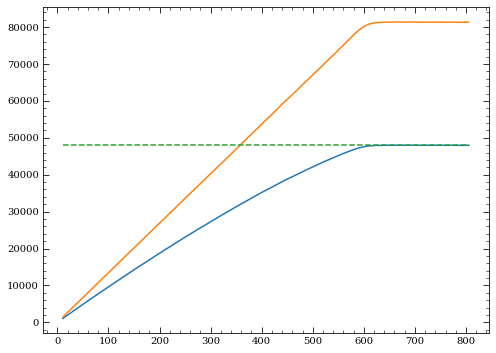

In [12]:
ix, iy = (100,100)
plt.plot(tarr, data[:,iy,ix])
plt.plot(tarr, data_lin[:,iy,ix])
plt.plot(tarr, np.ones(len(tarr))*sat_vals[iy,ix], ls='--')

In [13]:
# Perform fit to data in DN/sec
cf_arr = cube_fit(tarr, data, deg=2, sat_vals=sat_vals, sat_frac=0.5, fit_zero=False)
# Perform fit to data in DN/sec
cf_arr2 = cube_fit(tarr, data_lin, deg=1, sat_vals=well_depth, sat_frac=0.75, fit_zero=False)

64.96011057199505 125.78174899916237
81.93553837211475 182.67960372771864


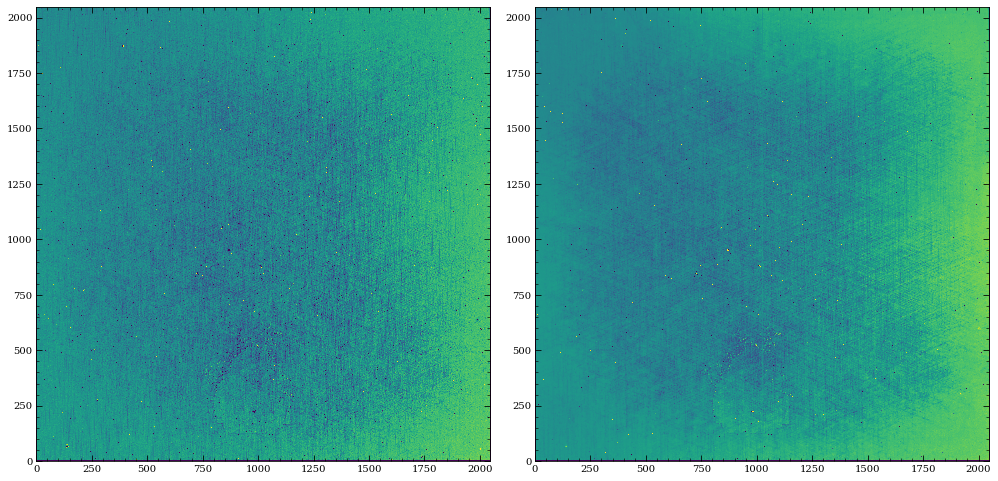

In [14]:
fig, axes = plt.subplots(1,2, figsize=(14,7))

# for i, im in enumerate([cf_sim[1,0:256,0:300], cf_arr[1,0:256,0:300]]):
for i, im in enumerate([cf_arr[1], cf_arr2[1]]):

    ax = axes[i]
    
    mn = np.median(im)
    std = robust.medabsdev(im)
    vmin, vmax = mn + 5*std*np.array([-1,1])

    print(vmin, vmax)

    ax.imshow(im, vmin=vmin, vmax=vmax)

fig.tight_layout()

0.9131705158396628 1.088735907326767
0.6516587840303316 1.3463889579372996


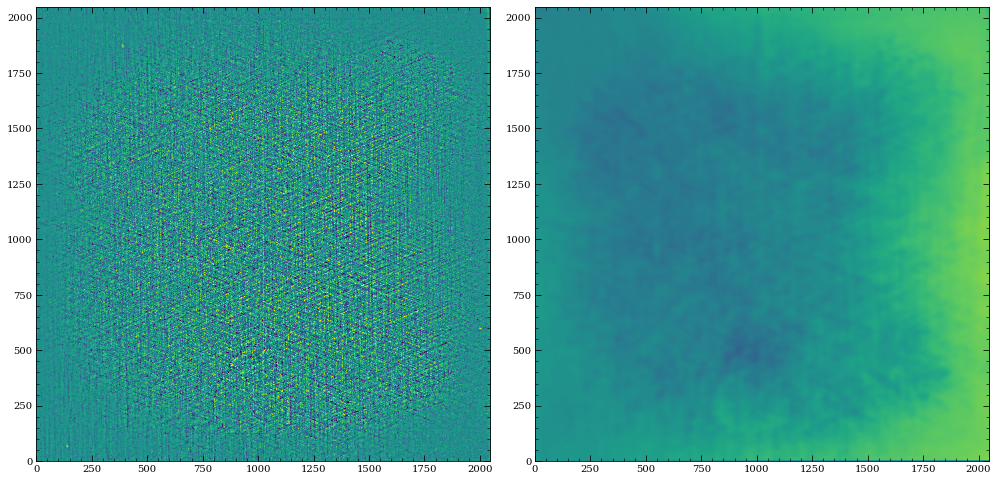

In [15]:
fig, axes = plt.subplots(1,2, figsize=(14,7))

# for i, im in enumerate([cf_sim[1,0:256,0:300], cf_arr[1,0:256,0:300]]):
for i, im in enumerate([dark_data.pflats, dark_data.lflats]):

    ax = axes[i]
    
    mn = np.median(im)
    std = robust.medabsdev(im)
    vmin, vmax = mn + 5*std*np.array([-1,1])

    print(vmin, vmax)

    ax.imshow(im, vmin=vmin, vmax=vmax)

fig.tight_layout()

## Simulated Data

In [16]:
# Create simulated ideal ramp
from copy import deepcopy

det_new = deepcopy(det)

# Get saturation times and assumed well depths
# tsat = time_to_sat(data, sat_vals, dt=det_new.time_group)
# tsat = time_to_sat(data_corr, sat_corr, dt=det_new.time_group)
# well_depth_dn = well_depth / det_new.gain

# Create an intrinsic slope (e-/sec), flat field info removed
im_slope = cf_arr2[1] / (dark_data.pflats * dark_data.lflats)
im_slope = im_slope*0 + np.median(im_slope)

# Apply flat fields
im_slope = apply_flat(im_slope, det_new, dark_data.pflats)
im_slope = apply_flat(im_slope, det_new, dark_data.lflats)

# im_slope[(~np.isfinite(im_slope)) | (np.isnan(im_slope))] = np.nanmedian(im_slope)
# im_slope *= det.gain  # e-/sec

In [17]:
# # Create simulated ideal ramp
# from copy import deepcopy

# det_new = deepcopy(det)

# # Get saturation times and assumed well depths
# # tsat = time_to_sat(data, sat_vals, dt=det_new.time_group)
# tsat = time_to_sat(data_corr, sat_corr, dt=det_new.time_group)
# well_depth_dn = well_depth / det_new.gain

# # Create a slope
# im_slope = well_depth_dn / tsat # DN/sec
# im_slope = im_slope*0 + np.median(im_slope) * dark_data.lflats
# im_slope[(~np.isfinite(im_slope)) | (np.isnan(im_slope))] = np.nanmedian(im_slope)
# im_slope *= det.gain  # e-/sec

In [18]:
ramp = sim_image_ramp(det_new, im_slope)
# Corresponding time values
tarr_new = det_new.times_group_avg

In [19]:
gc.collect()

15168

In [20]:
coeff_dict = dark_data.nonlinear_dict

cf_nonlin      = coeff_dict.get('cf_nonlin')

cflin0_mean    = coeff_dict.get('cflin0_mean')
cflin0_std     = coeff_dict.get('cflin0_std')
corr_slope     = coeff_dict.get('corr_slope')
corr_intercept = coeff_dict.get('corr_intercept')

use_legendre   = coeff_dict.get('use_legendre')
lxmap          = coeff_dict.get('lxmap')
deg            = coeff_dict.get('deg')

counts_cut     = coeff_dict.get('counts_cut')
cf_nonlin_low  = coeff_dict.get('cf_nonlin_low')

sat_vals       = coeff_dict.get('sat_vals')

In [21]:
print(cf_nonlin[:,100,100])
print(cf_nonlin_low[:,100,100])

[1.6527613  0.46108773 0.48164904 0.35801984 0.39472412 0.20668096
 0.18673692 0.05456316 0.03819168]
[-4.92155592e+06 -1.20425438e+07 -1.32774743e+07 -9.85291230e+06
 -5.26866768e+06 -2.03005088e+06 -5.40451823e+05 -8.96724977e+04
 -7.02837256e+03]


In [22]:
xpix, ypix = (100,100)

pval = ramp[:,ypix,xpix].reshape([-1,1,1])
sval = sat_vals[ypix,xpix].reshape([1,1])

coeff_dict = {
    'cf_nonlin'      : cf_nonlin[:,ypix,xpix].reshape([-1,1,1]),
    'cflin0_mean'    : cflin0_mean[ypix,xpix].reshape([-1,1]),
    'cflin0_std'     : cflin0_std[ypix,xpix].reshape([-1,1]),
    'corr_slope'     : corr_slope[:,ypix,xpix].reshape([-1,1,1]),
    'corr_intercept' : corr_intercept[:,ypix,xpix].reshape([-1,1,1]),
    'use_legendre'   : use_legendre,
    'lxmap'          : lxmap,
    'counts_cut'     : counts_cut,
    'cf_nonlin_low'  : cf_nonlin_low[:,ypix,xpix].reshape([-1,1,1]),
#     'cf_nonlin_low'  : None,
    'sat_vals'       : sat_vals[ypix,xpix].reshape([-1,1]),
}

pix_all = []
for i in trange(10):    
    test = apply_nonlin(pval, det_new, coeff_dict, randomize=False)
    
    pix = test.flatten()
    pix_all.append(pix)

  0%|          | 0/10 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/75 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/75 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/75 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/75 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/75 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/75 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/75 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/75 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/75 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/75 [00:00<?, ?it/s]

48017.84907910894


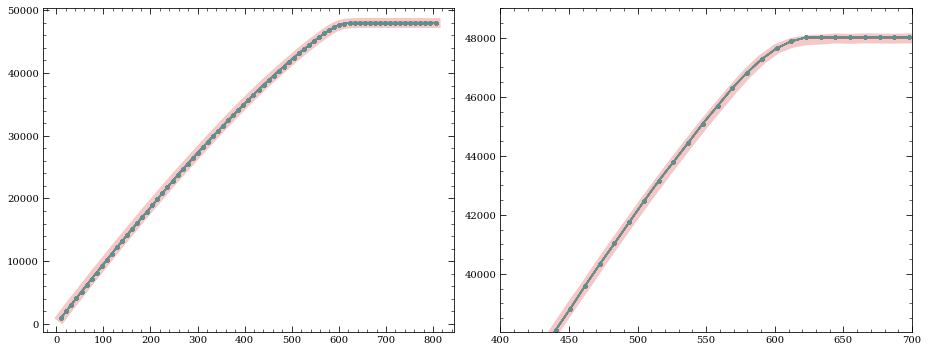

In [26]:
fig, axes = plt.subplots(1,2, figsize=(13,5))

for ax in axes:
    for pix in pix_all:    
        ax.plot(tarr_new, pix, marker='.')
    ax.plot(tarr, data[:,ypix,xpix], lw=10, color='C3', alpha=0.25)

sval = sat_vals[ypix,xpix]
print(sval)

# plt.plot(tvals, np.ones_like(tvals)*sval, ls='--')

# gain = jl_poly(pix[:,0], coeff[:,0], use_legendre=use_legendre, lxmap=lxmap)
# plt.plot(tvals, pix[:,0] / gain)

axes[1].set_xlim([400,700])
axes[1].set_ylim([sval-10000,sval+1000])

# axes[1].set_xlim([0,250])
# axes[1].set_ylim([0,20000])


fig.tight_layout()

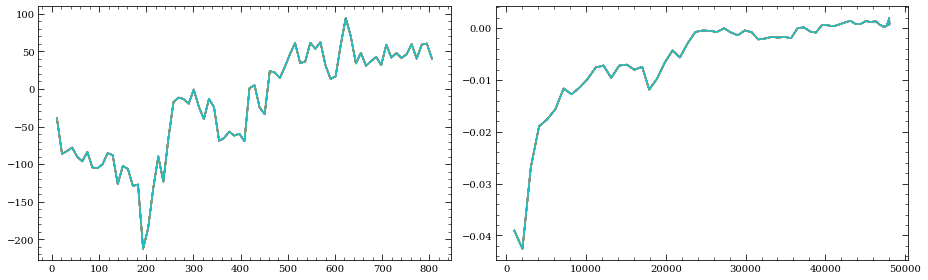

In [24]:
fig, axes = plt.subplots(1,2, figsize=(13,4))

ax = axes[0]
for pix in pix_all:    
    ax.plot(tarr_new, (pix-data[:,ypix,xpix]))

ax = axes[1]
for pix in pix_all:    
    ax.plot(pix, (pix-data[:,ypix,xpix])/pix)


fig.tight_layout()